## Load Car and NotCar Images

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
%matplotlib inline

In [2]:
def readTestingImages():
    images = glob.glob('vehicles_smallset/*/*.jpeg')
    images.extend(glob.glob('non-vehicles_smallset/*/*.jpeg'))
#     print (images)
    cars = []
    notcars = []

    for image in images:
        if 'image' in image or 'extra' in image:
            notcars.append(image)
        else:
            cars.append(image)
    return cars, notcars

cars, notcars = readTestingImages()

#     car_path = "vehicles/"
#     not_car_path = "non-vehicles/"
#     car_files = glob.glob(car_path + '/**/*.png', recursive=True)
#     not_car_files = glob.glob(not_car_path + '/**/*.png', recursive=True)
#     return car_files, not_car_files
# cars, notcars = readTestingImages()

Your function returned a count of 1196  cars and 1125  non-cars
of size:  (64, 64, 3)  and data type: uint8


(<matplotlib.axes._subplots.AxesSubplot at 0x109e05550>,
 <matplotlib.axes._subplots.AxesSubplot at 0x109e6a438>)

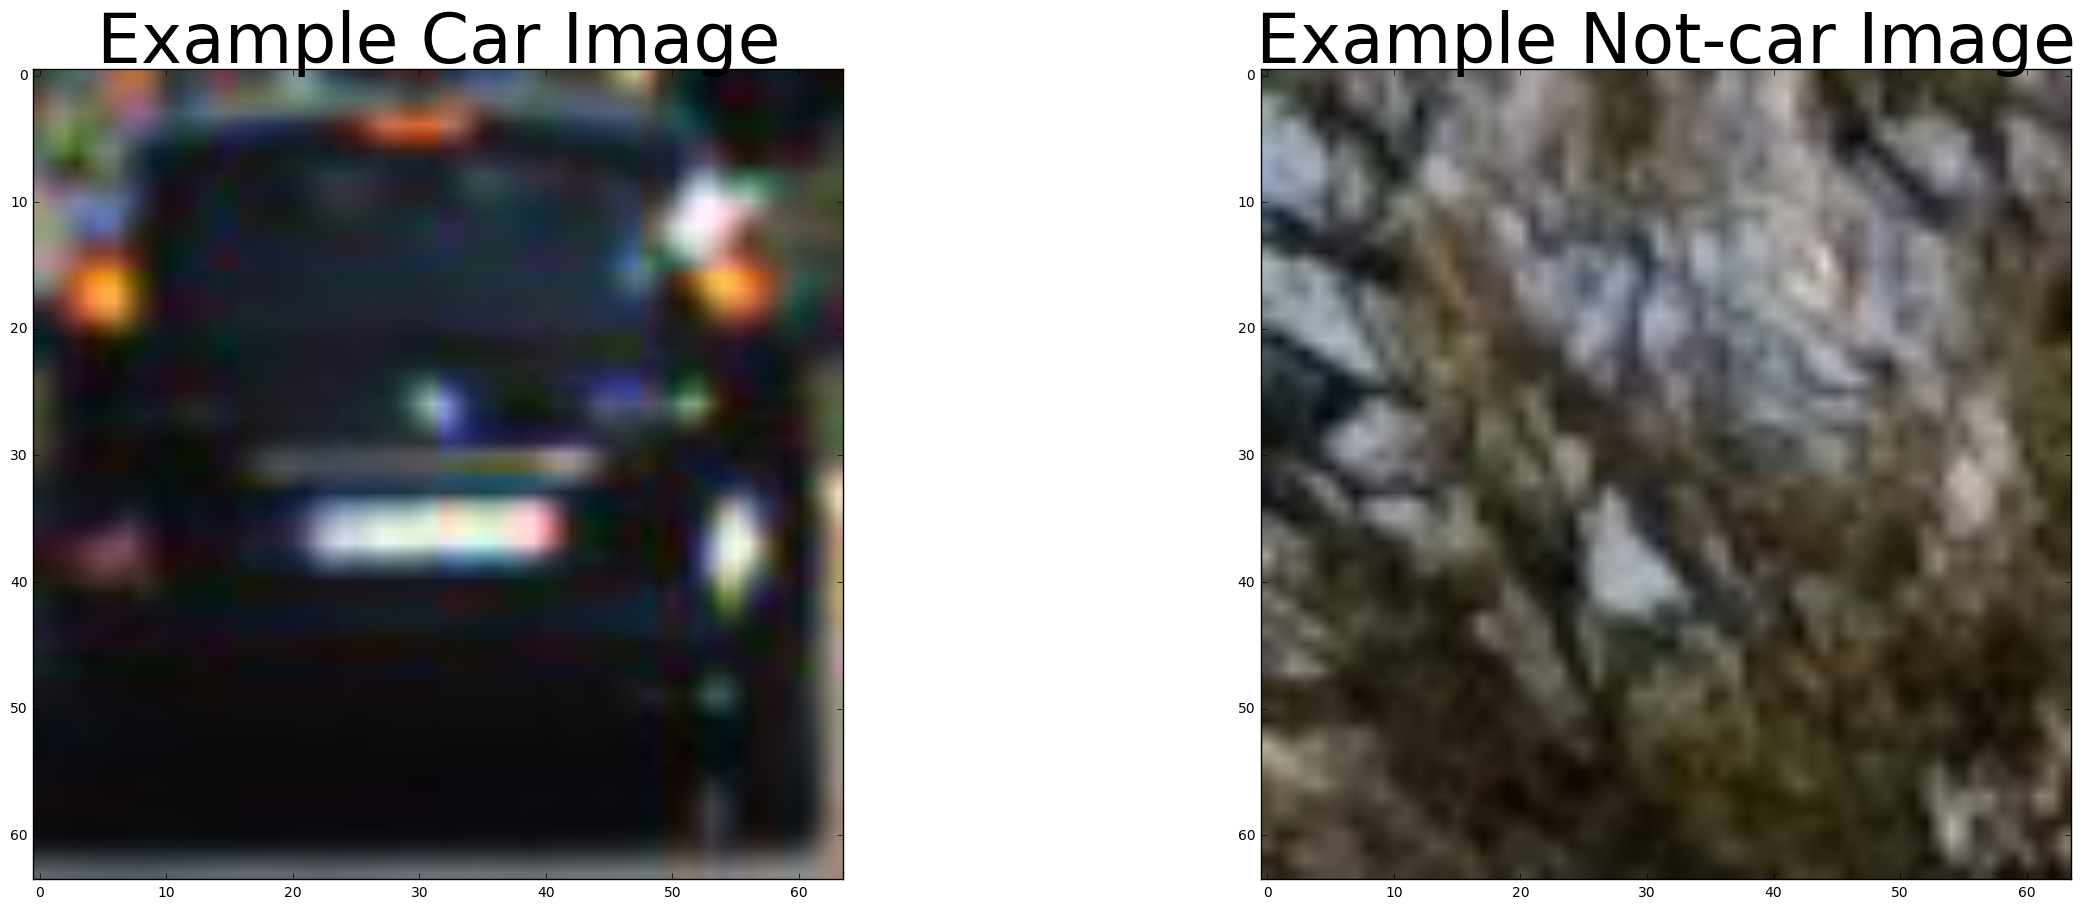

In [3]:
import matplotlib.image as mpimg
def show_comparison(img_before, img_after, title_before='', title_after=''):
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(img_before)
    ax1.set_title(title_before, fontsize=50)
    ax2.imshow(img_after)
    ax2.set_title(title_after, fontsize=50)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    return ax1, ax2

def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])

show_comparison(car_image, notcar_image, 'Example Car Image', 'Example Not-car Image')

## HOG Features

In [161]:
from skimage.feature import hog
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

(<matplotlib.axes._subplots.AxesSubplot at 0x144b9a630>,
 <matplotlib.axes._subplots.AxesSubplot at 0x11d8d6940>)

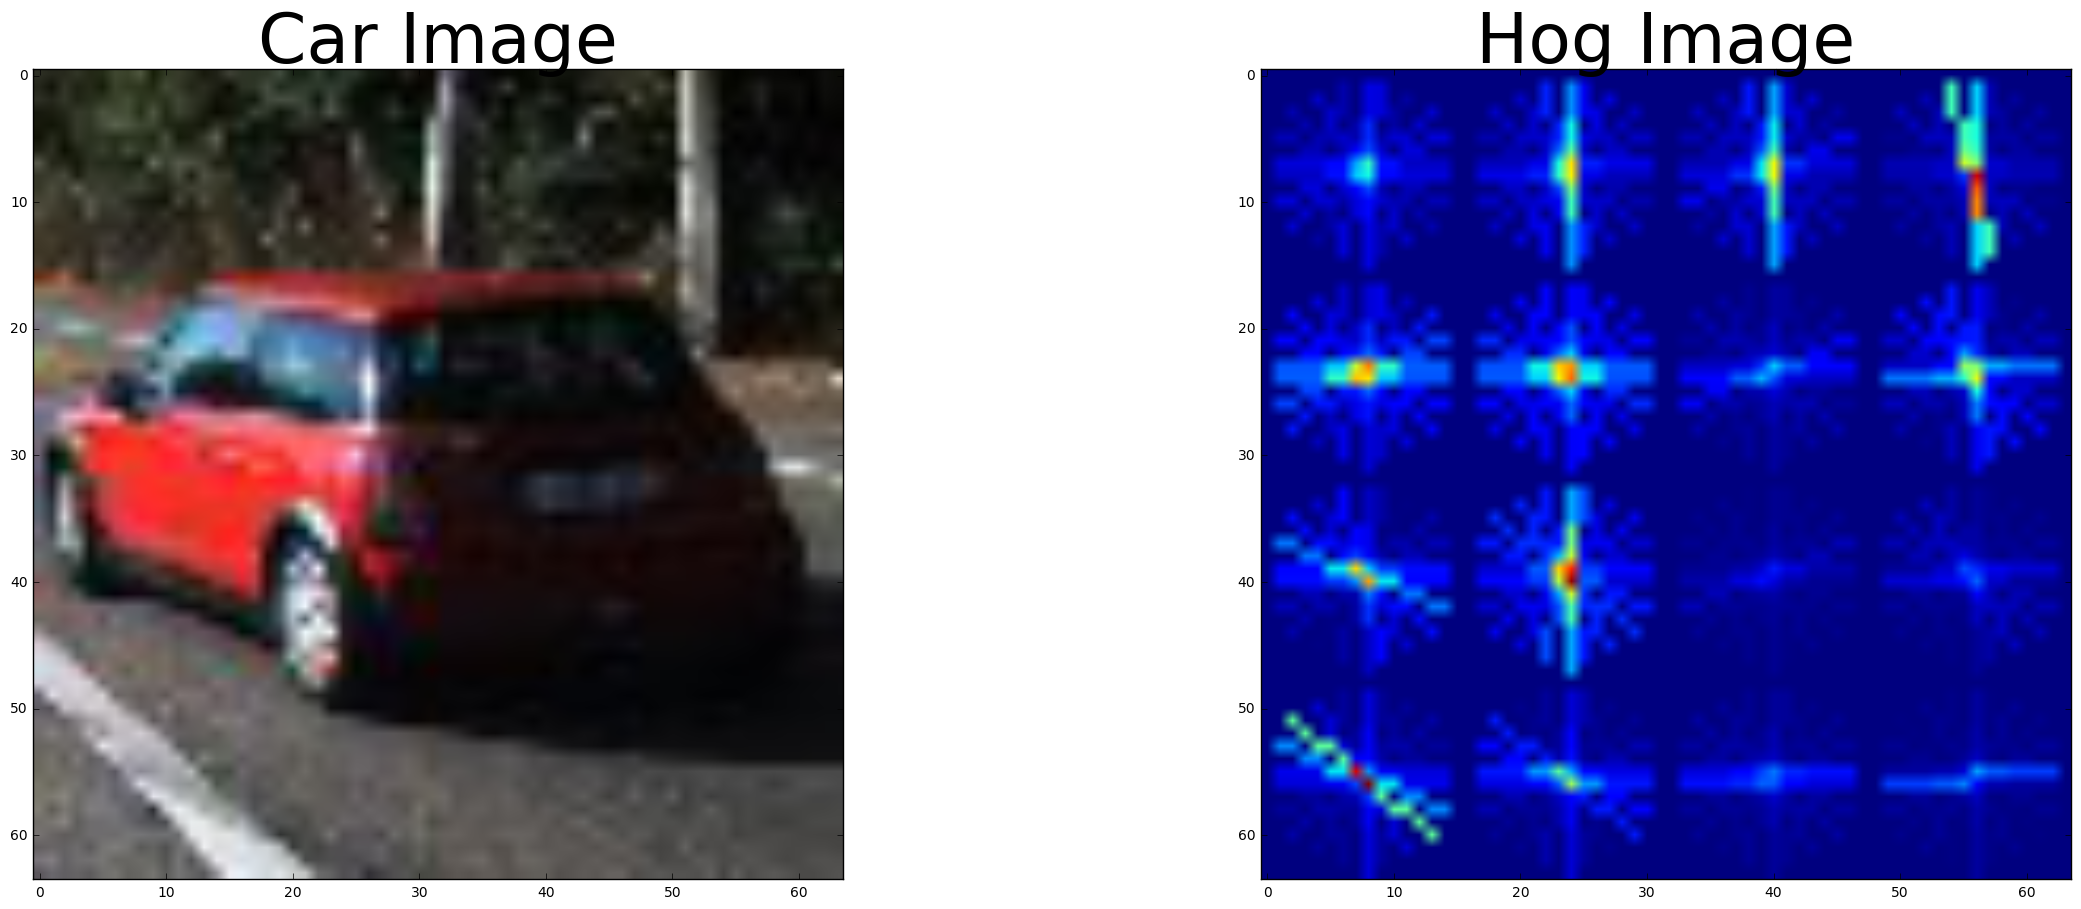

In [162]:
# Generate a random index to look at a car image
ind = np.random.randint(0, len(cars))
# Read in the image
image = mpimg.imread(cars[ind])
# Define HOG parameters
orient = 11
pix_per_cell = 16
cell_per_block = 2
# Call our function with vis=True to see an image output
gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
features, hog_image = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)
show_comparison(image, hog_image, 'Car Image', 'Hog Image')

## Spatial Color Bining Features

In [163]:
def bin_spatial(img, color_space='RGB', size=(32, 32)):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
    else: feature_image = np.copy(img)             
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(feature_image, size).ravel() 
    # Return the feature vector
    return features

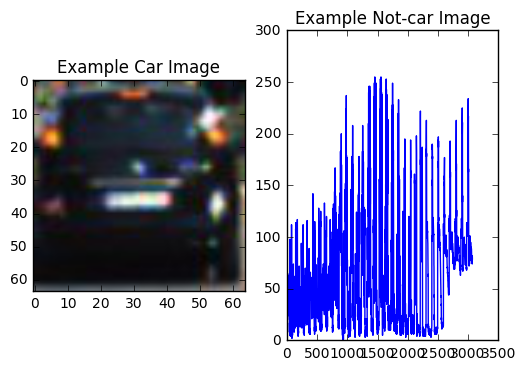

In [164]:
feature_vec = bin_spatial(image, color_space='RGB', size=(32, 32))

# Plot features
plt.figure()
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.plot(feature_vec)
plt.title('Example Not-car Image')


## Combine and Normalize Features

In [165]:
from sklearn.preprocessing import StandardScaler
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_color_features(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
#         features.append(np.concatenate((spatial_features, hist_features)))
        features.append(np.ravel(spatial_features))

    # Return list of feature vectors
    return features

def extract_hog_features(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        image = image.astype(np.float32) / 255
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=False))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=False)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features
    
def normalizeFeatures(features):
    # Create an array stack of feature vectors                     
    X = np.vstack(features).astype(np.float64)
    X_scaler = StandardScaler().fit(X)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    return X, scaled_X, X_scaler

def nomalizeSingleFeature(features):
    # Create an array stack of feature vectors                     
    X_scaler = StandardScaler().fit(features)
    # Apply the scaler to X
    scaled_X = X_scaler.transform(X)
    return scaled_X, X_scaler


car_hog_features size:  1188
car_color_features size:  768
car_features size:  1956


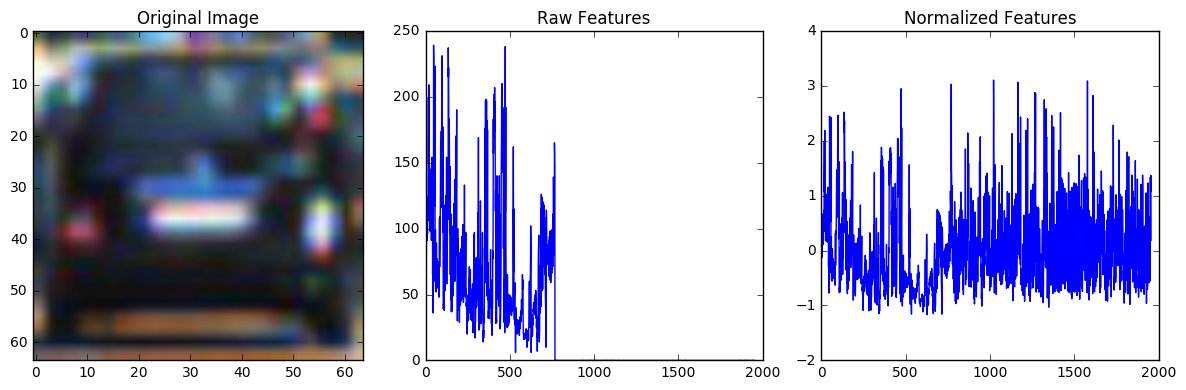

In [262]:
car_color_features = extract_color_features(cars, cspace='RGB', spatial_size=(16, 16),
                        hist_bins=32, hist_range=(0, 256))

notcar_color_features = extract_color_features(notcars, cspace='RGB', spatial_size=(16, 16),
                        hist_bins=32, hist_range=(0, 256))

car_hog_features = extract_hog_features(cars, cspace='YUV', orient=11, 
                        pix_per_cell=16, cell_per_block=2, 
                        hog_channel='ALL')

notcar_hog_features = extract_hog_features(notcars, cspace='YUV', orient=11, 
                        pix_per_cell=16, cell_per_block=2, 
                        hog_channel='ALL')

car_features = np.hstack((car_color_features,car_hog_features))
notcar_features = np.hstack((notcar_color_features, notcar_hog_features))

print('car_hog_features size: ', len(car_hog_features[0]))
print('car_color_features size: ', len(car_color_features[0]))
print('car_features size: ', len(car_features[0]))


if len(car_features) > 0:
    X, scaled_X, X_scaler = normalizeFeatures((car_features, notcar_features))
    car_ind = np.random.randint(0, len(cars))
    # Plot an example of raw and scaled features
    fig = plt.figure(figsize=(12,4))
    plt.subplot(131)
    plt.imshow(mpimg.imread(cars[car_ind]))
    plt.title('Original Image')
    plt.subplot(132)
    plt.plot(X[car_ind])
    plt.title('Raw Features')
    plt.subplot(133)
    plt.plot(scaled_X[car_ind])
    plt.title('Normalized Features')
    fig.tight_layout()
else: 
    print('Your function only returns empty feature vectors...')

## Classification - SVC

In [263]:
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.utils import shuffle
import time


# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
rand_state = np.random.randint(0, 100)
scaled_X, y = shuffle(scaled_X, y)
X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))
print('Training sample size:', len(X_train))

# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1956
Training sample size: 1856
0.24 Seconds to train SVC...
Test Accuracy of SVC =  0.9935
My SVC predicts:  [ 0.  0.  0.  0.  1.  0.  1.  1.  0.  1.]
For these 10 labels:  [ 0.  0.  0.  0.  1.  0.  1.  1.  0.  1.]
0.0059 Seconds to predict 10 labels with SVC


## Sliding Window

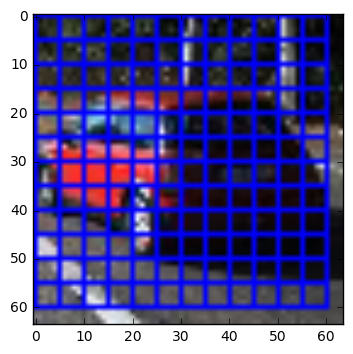

In [264]:
# Here is your draw_boxes function from the previous exercise
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy
    
def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

windows = slide_window(image, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(10, 10), xy_overlap=(0.5, 0.5))
                       
window_img = draw_boxes(image, windows, color=(0, 0, 255), thick=1)                    
plt.imshow(window_img)




## Find Cars

In [265]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins, findBox=False):
    
    boxes = []
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]
    
    ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
#     print ('resize image size: ', ctrans_tosearch.shape)
    
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ctrans_tosearch.shape[1] // pix_per_cell)-1 #159
    nyblocks = (ctrans_tosearch.shape[0] // pix_per_cell)-1 #31
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1#7
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step #76
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step #12
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract the image patch
            subimg = cv2.resize(img_tosearch[ytop:ytop+window, xleft:xleft+window], (64,64), interpolation = cv2.INTER_AREA)
          
            # Get color features
            spatial_features = bin_spatial(subimg, size=spatial_size)

            test_features = X_scaler.transform(np.hstack((spatial_features, hog_features)).reshape(1,-1))
            
#             test_prediction = svc.predict(test_features)
            test_prediction = svc.decision_function(test_features)

            if test_prediction > 0.95:
#             if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                if findBox:
                    boxes.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))
                else:
                    cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                
#     print('test_feature size: ', test_features.shape)
    if findBox:
        return boxes
    else:
        return draw_img

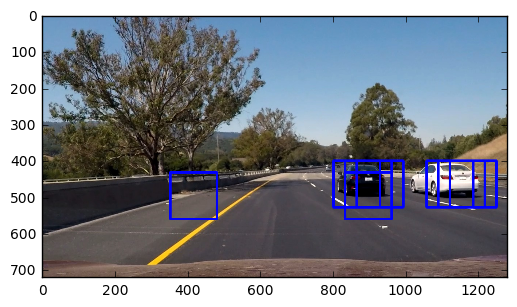

In [266]:
test_img = mpimg.imread('test_images/test6.jpg')

draw_img = find_cars(test_img, ystart=400, ystop=656, scale=2,svc=svc, X_scaler=X_scaler, orient=11, pix_per_cell=16, cell_per_block=2, spatial_size=(16, 16), hist_bins=32)
plt.imshow(draw_img)
# fig = plt.figure(figsize=(12,4))
# plt.subplot(131)
# plt.imshow(subimg)
# plt.title('Original Image')
# plt.subplot(132)
# plt.plot(nf)
# plt.title('Raw Features')
# plt.subplot(133)
# plt.plot(f.reshape(-1,1))
# plt.title('Normalized Features')
# fig.tight_layout()

### Heat Map and Filtering

In [267]:
heat = np.zeros_like(test_img[:,:,0]).astype(np.float)
# scales = [1]
scales = np.linspace(1.0, 2.0, 10)
box_list = []
for scale in scales:
    boxes = find_cars(test_img,
                      ystart=400,
                      ystop=656,
                      scale=scale,
                      svc=svc,
                      X_scaler=X_scaler,
                      orient=11,
                      pix_per_cell=16,
                      cell_per_block=2,
                      spatial_size=(16,16),
                      hist_bins=32,
                    findBox=True)
    
    box_list.extend(boxes)


In [268]:
from scipy.ndimage.measurements import label
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes
    
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

heat = np.zeros_like(test_img[:,:,0]).astype(np.float)
# Add heat to each box in box list
heat = add_heat(heat, box_list)
print(heat.shape)
# Apply threshold to help remove false positives
heat = apply_threshold(heat,6)
# Visualize the heatmap when displaying    
heatmap = np.clip(heat, 0, 255)
# Find final boxes from heatmap using label function
labels = label(heatmap)
draw_img = draw_labeled_bboxes(np.copy(test_img), labels)

(720, 1280)


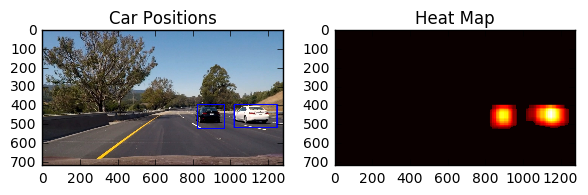

In [269]:
fig = plt.figure()
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()

## Pipe Line

In [270]:
class Pipe_Line():
    def __init__(self, svc, X_scaler):
        from collections import deque
        self.zero_heat = np.zeros((720,1280), dtype=np.float)
        self.scales = np.linspace(1.0, 2.0, 10)
        self.box_list = []
        self.ystart = 400
        self.ystop = 656

        self.orient = 11
        self.pix_per_cell = 16
        self.cell_per_block = 2

        self.spatial_size = (16, 16)
        self.hist_bins = 32
        self.hist_range = (0, 256)
        
        self.svc = svc
        self.X_scaler = X_scaler
        
        self.heatmapQueue = deque(maxlen = 5)
    
    def process(self, image):
        heat = self.zero_heat.copy()
        box_list = []
        for scale in self.scales:
            boxes = find_cars(image,
                              ystart=self.ystart,
                              ystop=self.ystop,
                              scale=scale,
                              svc=self.svc,
                              X_scaler=self.X_scaler,
                              orient=self.orient,
                              pix_per_cell=self.pix_per_cell,
                              cell_per_block=self.cell_per_block,
                              spatial_size=self.spatial_size,
                              hist_bins=self.hist_bins,
                              findBox=True)
            if boxes:
                box_list.extend(boxes)
        # Add heat to each box in box list
        heat = add_heat(heat, box_list)
        # Add heat to heat map queue
        self.heatmapQueue.append(heat)
        heatSum = self.zero_heat.copy()
        for h in self.heatmapQueue:
            heatSum += h
        # Apply threshold to help remove false positives
        heat = apply_threshold(heatSum, 40)
        # Visualize the heatmap when displaying
        heatmap = np.clip(heat, 0, 255)
        # Find final boxes from heatmap using label function
        labels = label(heatmap)
        draw_img = draw_labeled_bboxes(np.copy(image), labels)
        return draw_img

## Video Process

In [271]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

pipe_line = Pipe_Line(svc, X_scaler)
clip1 = VideoFileClip("project_video.mp4")
output = 'project_video_output.mp4'
white_clip = clip1.fl_image(pipe_line.process) #NOTE: this function expects color images!!
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4



100%|█████████▉| 1260/1261 [28:46<00:01,  1.40s/it]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

CPU times: user 26min 53s, sys: 2min 11s, total: 29min 4s
Wall time: 28min 47s
